In [64]:
import os
from typing import List, Optional, Tuple

import numpy as np 
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")



In [65]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Data

In [66]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


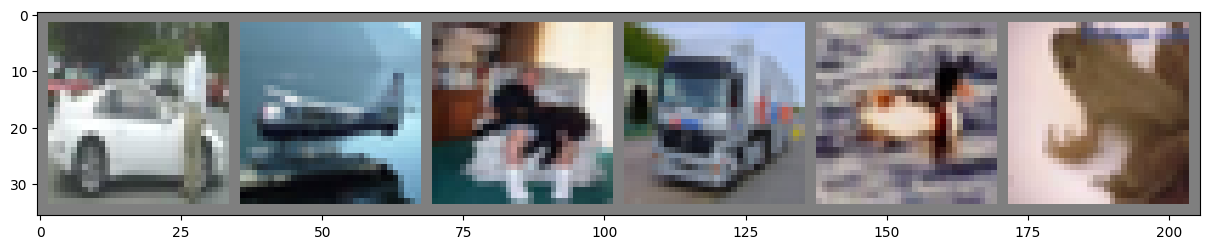

car   plane dog   truck bird  frog 


In [67]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


img_to_show = 6

def imshow(img, figsize=(15,15)):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=figsize)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:img_to_show]))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(img_to_show)))

## ResNet & ResNeXt block

In [68]:
class ResBlock(nn.Module):
    """
    resBlock_type: 'default', 'bottleneck', 'ResNeXt'
    """
    def __init__(
        self, 
        in_channels: int, 
        mid_channels: int, 
        out_channels: int, 
        resBlock_type: str = 'default',
        stride: int = 1, 
        padding: int = 1,
        kernel_size: int = 3, 
        activations: List[nn.Module] = [nn.ReLU()],
        cardinality: Optional[int] = 1,
        debug_mode: bool = False,
        # downsample: Optional[nn.Module] = None
    ):
        super(ResBlock, self).__init__()
        self.debug_mode = debug_mode
        self.activations = activations + activations[-1:]*(2 - len(activations))
        # self.activations += [nn.ReLU()]*(2 - len(activations))
        self.downsample = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)
        self.cardinality = cardinality
        if (resBlock_type == 'default'):
                self.layers = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
                nn.BatchNorm2d(out_channels),
                self.activations[0],
                nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=padding),
                nn.BatchNorm2d(out_channels)
            )
            
        elif(resBlock_type == 'bottleneck'):
            self.layers = nn.Sequential(
                nn.Conv2d(in_channels, mid_channels, kernel_size=1, stride=1),
                nn.BatchNorm2d(mid_channels),
                self.activations[0],
                
                nn.Conv2d(mid_channels, mid_channels, kernel_size=kernel_size, stride=stride, padding=padding),
                nn.BatchNorm2d(mid_channels),
                self.activations[1],
                
                nn.Conv2d(mid_channels, out_channels, kernel_size=1, stride=1),
                nn.BatchNorm2d(out_channels)
            )

        elif(resBlock_type == 'ResNeXt'):
            self.layers = nn.Sequential(
                nn.Conv2d(in_channels, mid_channels, kernel_size=1, stride=1),
                nn.BatchNorm2d(mid_channels),
                self.activations[0],
                nn.Conv2d(mid_channels, mid_channels, kernel_size=kernel_size, stride=stride, padding=1, groups=cardinality),
                nn.BatchNorm2d(mid_channels),
                self.activations[1],
                nn.Conv2d(mid_channels, out_channels, kernel_size=1, stride=1),
                nn.BatchNorm2d(out_channels)
            )
            
        else:
            raise Exception(f'Unknown block type: {resBlock_type}')
    
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        self.shortcut = x
        x = self.layers(x)

        if self.debug_mode:
            print(f'{x.shape = }')
            print(f'{self.shortcut.shape = }')
            print(f'{self.downsample = }')
            print(f'{(self.downsample(self.shortcut)).shape = }')
        
        x = self.activations[-1](x + self.downsample(self.shortcut)) # transform shortcut?
        return x 
        

In [69]:
print(ResBlock(2, 5, 3, stride=2, debug_mode=True)(torch.rand(1, 2, 32, 32)).shape)
print()
print(ResBlock(2, 5, 3, resBlock_type='bottleneck', stride=2, debug_mode=True)(torch.rand(1, 2, 32, 32)).shape)
print()
print(ResBlock(2, 5, 3, resBlock_type='ResNeXt', stride=2, debug_mode=True)(torch.rand(1, 2, 32, 32)).shape)
print()

x.shape = torch.Size([1, 3, 16, 16])
self.shortcut.shape = torch.Size([1, 2, 32, 32])
self.downsample = Conv2d(2, 3, kernel_size=(1, 1), stride=(2, 2))
(self.downsample(self.shortcut)).shape = torch.Size([1, 3, 16, 16])
torch.Size([1, 3, 16, 16])

x.shape = torch.Size([1, 3, 16, 16])
self.shortcut.shape = torch.Size([1, 2, 32, 32])
self.downsample = Conv2d(2, 3, kernel_size=(1, 1), stride=(2, 2))
(self.downsample(self.shortcut)).shape = torch.Size([1, 3, 16, 16])
torch.Size([1, 3, 16, 16])

x.shape = torch.Size([1, 3, 16, 16])
self.shortcut.shape = torch.Size([1, 2, 32, 32])
self.downsample = Conv2d(2, 3, kernel_size=(1, 1), stride=(2, 2))
(self.downsample(self.shortcut)).shape = torch.Size([1, 3, 16, 16])
torch.Size([1, 3, 16, 16])



## ResNet layer

In [70]:
# sequence of the blocks of the same type?
class ResLayer(nn.Module):
    def __init__(
        self,
        in_channels: int = 1,  
        mid_channels: Optional[int] = None,  
        out_channels: int = 1,
        block_type: str = 'default',
        num_blocks: int = 5,
        stride: int = 1,
        activations: List[nn.Module] = [nn.ReLU()],
        padding: int = 1,
        kernel_size: int = 3, 
        cardinality: int = 1,
    ):
        super(ResLayer, self).__init__()
        mid_channels = in_channels if (mid_channels is None) else mid_channels
            
        if num_blocks < 2:
            self.layer = nn.Sequential(ResBlock(in_channels, mid_channels, out_channels, 
                        block_type, stride, padding, kernel_size, activations, cardinality))
        else:
            self.layer = nn.Sequential(
                ResBlock(in_channels, mid_channels, mid_channels, 
                            block_type, stride, padding, kernel_size, activations, cardinality),
                *[ResBlock(in_channels, mid_channels, mid_channels, 
                    block_type, stride, padding, kernel_size, activations, cardinality) 
                    for _ in range(num_blocks - 2)],
                ResBlock(mid_channels, mid_channels, out_channels, 
                            block_type, stride, padding, kernel_size, activations, cardinality),
            )
        
    def forward(self, x):
        x = self.layer(x)
        return x

In [71]:
ResLayer(2, 4, 2)

ResLayer(
  (layer): Sequential(
    (0): ResBlock(
      (downsample): Conv2d(2, 4, kernel_size=(1, 1), stride=(1, 1))
      (layers): Sequential(
        (0): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResBlock(
      (downsample): Conv2d(2, 4, kernel_size=(1, 1), stride=(1, 1))
      (layers): Sequential(
        (0): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )

## ResNet

In [72]:
class ResNet(nn.Module):
    """
    architecture: Optional[int]: 18/32/50/101/152
    """
    def __init__(
        self,
        architecture: Optional[int] = None, 
        layer: Optional[List[int]] = None,
        block_types: Optional[List[str]] = ['default'],
        activations: List[nn.Module] = [nn.ReLU()],
        classes: int = 100,
        cardinality: Optional[int] = 1,
        img_channels: int = 3, 
        img_height: int = 32, 
        img_width: int = 32,
    ):
        super(ResNet, self).__init__()
        if architecture is not None:
            self.channels = [64, 64, 128, 256, 512]
            if (architecture == 18):
                self.layers = [2, 2, 2, 2]
                self.blockType = ['default']*4
                
            elif (architecture == 50):
                self.layers = [3, 4, 6, 3]
                self.blockType = ['default']*4
                            
            elif (architecture == 101):
                self.layers = [3, 4, 23, 3]
                self.blockType = ['bottleneck']*4
                            
            elif (architecture == 152):
                self.layers = [3, 8, 36, 3]
                self.blockType = ['bottleneck']*4
                
            else:
                raise Exception(f'Unknown architecture: ResNet{architecture}. Only 18/32/50/101/152 available')
        
        else:
            self.layers = layer
            self.blockType = block_types + (['default']*(len(layer) - len(block_types)))
            self.channels = [64] + [2**(val + 6) for val in range(len(layer))]
        
        self.conv1 = nn.Conv2d(
            in_channels=img_channels, 
            out_channels=64, 
            kernel_size=7,
            stride=2,
            padding=3,
            )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.convX = nn.Sequential(
            *[ResLayer(
                    in_channels=self.channels[idx], 
                    out_channels=self.channels[idx+1],
                    block_type=self.blockType[idx],
                    num_blocks=layer,
                    activations=activations,
                    cardinality=cardinality
                )
                for idx, layer in enumerate(self.layers)]
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(self.channels[-1], classes)
        
    def forward(self, x: torch.Tensor):
        x = self.conv1(x)  
        x = self.maxpool(x)
        x = self.convX(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x      
            
        
        

In [73]:
ResNet(18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (convX): Sequential(
    (0): ResLayer(
      (layer): Sequential(
        (0): ResBlock(
          (downsample): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          (layers): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
            (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (1): ResBlock(
          (downsample): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          (layers): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            

## Training & testing

In [74]:
def get_accuracy(model, loader, device):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad(): 
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

In [75]:
def test_model(model, num_epochs=100, device=device, name=''):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_data = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
#           accuracy made training significantly longer
#         test_accuracy = get_accuracy(model, testloader, device)
#         train_accuracy = get_accuracy(model, trainloader, device)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')
        loss_data.append(running_loss/len(train_loader))
#         print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Test accuracy: {test_accuracy:.1f}%, , Train accuracy: {train_accuracy:.1f}%')
    plt.plot(np.arange(1, num_epochs + 1), loss_data, label = 'Loss')
    plt.title(name)
    plt.legend()
    plt.show()

### ResNet18

Epoch [1/100], Loss: 2.0030
Epoch [2/100], Loss: 1.8111
Epoch [3/100], Loss: 1.7295
Epoch [4/100], Loss: 1.6404
Epoch [5/100], Loss: 1.5917
Epoch [6/100], Loss: 1.5126
Epoch [7/100], Loss: 1.4600
Epoch [8/100], Loss: 1.4072
Epoch [9/100], Loss: 1.3433
Epoch [10/100], Loss: 1.2871
Epoch [11/100], Loss: 1.2346
Epoch [12/100], Loss: 1.1496
Epoch [13/100], Loss: 1.1292
Epoch [14/100], Loss: 1.0525
Epoch [15/100], Loss: 1.0163
Epoch [16/100], Loss: 0.9375
Epoch [17/100], Loss: 0.8609
Epoch [18/100], Loss: 0.8442
Epoch [19/100], Loss: 0.7574
Epoch [20/100], Loss: 0.7521
Epoch [21/100], Loss: 0.6874
Epoch [22/100], Loss: 0.6510
Epoch [23/100], Loss: 0.5767
Epoch [24/100], Loss: 0.5160
Epoch [25/100], Loss: 0.4832
Epoch [26/100], Loss: 0.4565
Epoch [27/100], Loss: 0.4067
Epoch [28/100], Loss: 0.4068
Epoch [29/100], Loss: 0.3394
Epoch [30/100], Loss: 0.3319
Epoch [31/100], Loss: 0.3012
Epoch [32/100], Loss: 0.2820
Epoch [33/100], Loss: 0.2363
Epoch [34/100], Loss: 0.2461
Epoch [35/100], Loss: 0

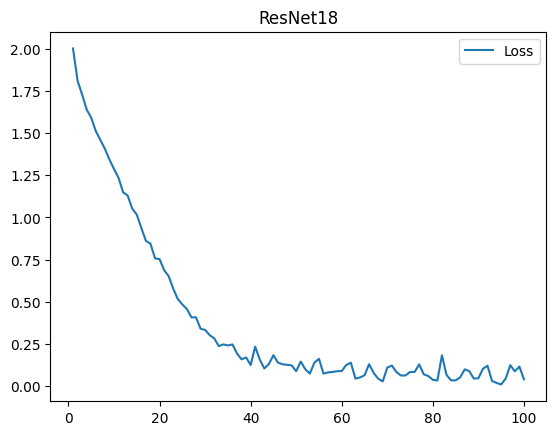

In [76]:
test_model(ResNet(architecture=18, classes=10), 100, device, 'ResNet18')

### ResNet50

Epoch [1/100], Loss: 2.1738
Epoch [2/100], Loss: 1.9583
Epoch [3/100], Loss: 1.9037
Epoch [4/100], Loss: 1.8444
Epoch [5/100], Loss: 1.7627
Epoch [6/100], Loss: 1.7201
Epoch [7/100], Loss: 1.6407
Epoch [8/100], Loss: 1.6250
Epoch [9/100], Loss: 1.5346
Epoch [10/100], Loss: 1.4901
Epoch [11/100], Loss: 1.4059
Epoch [12/100], Loss: 1.3631
Epoch [13/100], Loss: 1.2883
Epoch [14/100], Loss: 1.2805
Epoch [15/100], Loss: 1.2188
Epoch [16/100], Loss: 1.1642
Epoch [17/100], Loss: 1.1143
Epoch [18/100], Loss: 1.0554
Epoch [19/100], Loss: 0.9895
Epoch [20/100], Loss: 0.9630
Epoch [21/100], Loss: 0.9255
Epoch [22/100], Loss: 0.8598
Epoch [23/100], Loss: 0.8230
Epoch [24/100], Loss: 0.7834
Epoch [25/100], Loss: 0.7287
Epoch [26/100], Loss: 0.6485
Epoch [27/100], Loss: 0.6258
Epoch [28/100], Loss: 0.6145
Epoch [29/100], Loss: 0.5447
Epoch [30/100], Loss: 0.5112
Epoch [31/100], Loss: 0.5266
Epoch [32/100], Loss: 0.5084
Epoch [33/100], Loss: 0.3953
Epoch [34/100], Loss: 0.4198
Epoch [35/100], Loss: 0

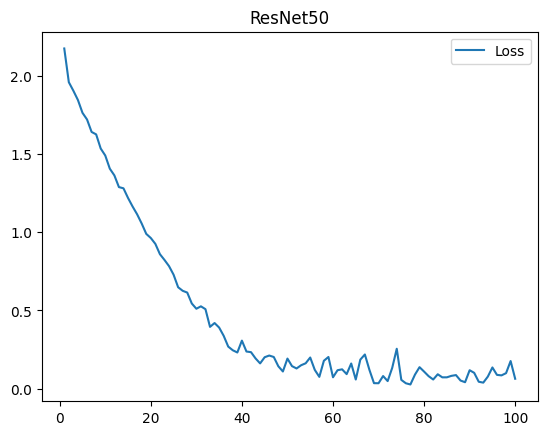

In [78]:
test_model(ResNet(architecture=50, classes=10), 100, device, 'ResNet50')

### ResNet101

Epoch [1/100], Loss: 2.3127
Epoch [2/100], Loss: 2.2649
Epoch [3/100], Loss: 2.2393
Epoch [4/100], Loss: 2.2139
Epoch [5/100], Loss: 2.1826
Epoch [6/100], Loss: 2.1589
Epoch [7/100], Loss: 2.1463
Epoch [8/100], Loss: 2.1165
Epoch [9/100], Loss: 2.0918
Epoch [10/100], Loss: 2.0524
Epoch [11/100], Loss: 2.0350
Epoch [12/100], Loss: 2.0119
Epoch [13/100], Loss: 2.0017
Epoch [14/100], Loss: 1.9760
Epoch [15/100], Loss: 1.9530
Epoch [16/100], Loss: 1.9345
Epoch [17/100], Loss: 1.9174
Epoch [18/100], Loss: 1.9351
Epoch [19/100], Loss: 1.9125
Epoch [20/100], Loss: 1.9165
Epoch [21/100], Loss: 1.8868
Epoch [22/100], Loss: 1.8401
Epoch [23/100], Loss: 1.8320
Epoch [24/100], Loss: 1.7986
Epoch [25/100], Loss: 1.7815
Epoch [26/100], Loss: 1.7846
Epoch [27/100], Loss: 1.7714
Epoch [28/100], Loss: 1.7213
Epoch [29/100], Loss: 1.7218
Epoch [30/100], Loss: 1.6870
Epoch [31/100], Loss: 1.6879
Epoch [32/100], Loss: 1.6644
Epoch [33/100], Loss: 1.6713
Epoch [34/100], Loss: 1.6659
Epoch [35/100], Loss: 1

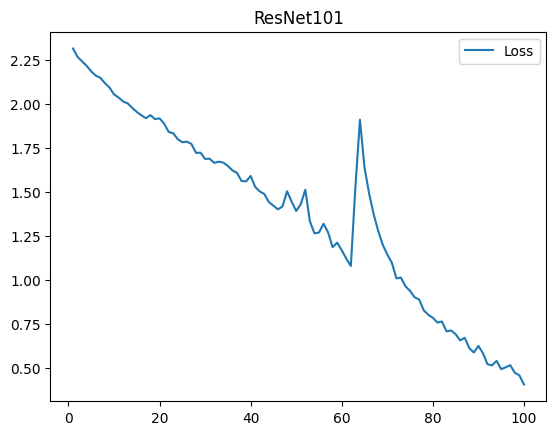

In [79]:
test_model(ResNet(architecture=101, classes=10), 100, device, 'ResNet101')

### ResNet152

Epoch [1/25], Loss: 2.3172
Epoch [2/25], Loss: 2.2859
Epoch [3/25], Loss: 2.2904
Epoch [4/25], Loss: 2.2900
Epoch [5/25], Loss: 2.2896
Epoch [6/25], Loss: 2.2885
Epoch [7/25], Loss: 2.2843
Epoch [8/25], Loss: 2.2894
Epoch [9/25], Loss: 2.2875
Epoch [10/25], Loss: 2.2877
Epoch [11/25], Loss: 2.2866
Epoch [12/25], Loss: 2.2880
Epoch [13/25], Loss: 2.2863
Epoch [14/25], Loss: 2.2796
Epoch [15/25], Loss: 2.2667
Epoch [16/25], Loss: 2.2635
Epoch [17/25], Loss: 2.2584
Epoch [18/25], Loss: 2.2538
Epoch [19/25], Loss: 2.2544
Epoch [20/25], Loss: 2.2483
Epoch [21/25], Loss: 2.2467
Epoch [22/25], Loss: 2.2496
Epoch [23/25], Loss: 2.2471
Epoch [24/25], Loss: 2.2524
Epoch [25/25], Loss: 2.2493


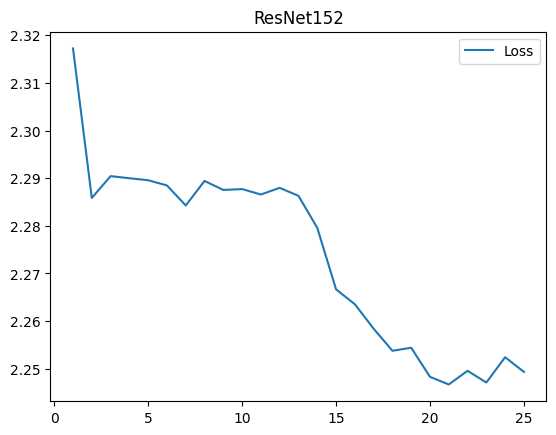

In [81]:
test_model(ResNet(architecture=152, classes=10), 25, device, 'ResNet152')

### ResNeXt

Epoch [1/50], Loss: 2.2359
Epoch [2/50], Loss: 1.9960
Epoch [3/50], Loss: 1.8723
Epoch [4/50], Loss: 1.7809
Epoch [5/50], Loss: 1.7201
Epoch [6/50], Loss: 1.6546
Epoch [7/50], Loss: 1.5954
Epoch [8/50], Loss: 1.5667
Epoch [9/50], Loss: 1.5068
Epoch [10/50], Loss: 1.4572
Epoch [11/50], Loss: 1.4365
Epoch [12/50], Loss: 1.3901
Epoch [13/50], Loss: 1.3827
Epoch [14/50], Loss: 1.3576
Epoch [15/50], Loss: 1.2851
Epoch [16/50], Loss: 1.2575
Epoch [17/50], Loss: 1.2719
Epoch [18/50], Loss: 1.2371
Epoch [19/50], Loss: 1.2022
Epoch [20/50], Loss: 1.1572
Epoch [21/50], Loss: 1.1325
Epoch [22/50], Loss: 1.1170
Epoch [23/50], Loss: 1.0951
Epoch [24/50], Loss: 1.0503
Epoch [25/50], Loss: 1.0162
Epoch [26/50], Loss: 1.0097
Epoch [27/50], Loss: 0.9875
Epoch [28/50], Loss: 0.9494
Epoch [29/50], Loss: 0.9021
Epoch [30/50], Loss: 0.8626
Epoch [31/50], Loss: 0.8308
Epoch [32/50], Loss: 0.8054
Epoch [33/50], Loss: 0.7768
Epoch [34/50], Loss: 0.7270
Epoch [35/50], Loss: 0.6714
Epoch [36/50], Loss: 0.6856
E

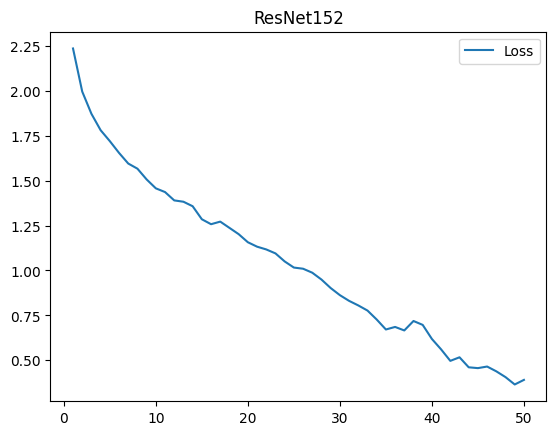

In [83]:
test_model(ResNet(layer = [2, 4, 6, 2], block_types = ['ResNeXt', 'ResNeXt', 'ResNeXt'], cardinality=8, classes=10), 50, device, 'ResNet152')